In [ ]:
import numpy as np
import wbls_code
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import wbls_vars



import os
from wbls_code import getDatetime
fileList=np.array([getDatetime(file,format='str')[-5:] for file in os.listdir('/media/disk_c/WbLS-DATA/csv')])

import numpy as np
u=np.unique(fileList,return_counts=True)

toDo=u[1]-1

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1], popt[2])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)



def gauss(x, mu, sigma,scale):
    arg = (x-mu)/sigma
    N = scale/np.sqrt(2*np.pi)/sigma
    return N*np.exp(-0.5*arg*arg)

def polya(n,mu,b):
    if b==0:
        r=math.pow(mu,n)*math.exp(-mu)/math.gamma(n+1)
    else:
        r=math.pow(mu,n)*math.pow(1+b*mu,-n-(1/b))*math.prod([(b*i)+1 for i in range(1,n)])/math.gamma(n+1)
    return r

def compoundGaussianPolya(x,sigma0,sigma,mu,b,numPE):
    toSum=np.empty([50,len(x)])
    for n in range(50):
        prob=polya(n,numPE,b)*gauss(x,n*mu,math.sqrt(n*math.pow(sigma,2)+math.pow(sigma0,2)),1)
        toSum[n]=prob
    return np.sum(toSum,axis=0)



root='/media/disk_d/gglawley/consolidated/phase3/muon_full_test_240430T0944.root'
#root='/media/disk_d/WbLS-DATA/raw_root/phase3/muon/muon_full_test_240512T0846_5.root'
#root=sys.argv[1]

print(root)

r=wbls_code.arrays(root)
r.skip(['adc_b1_ch0','adc_b2_ch15','adc_b4_ch13','adc_b4_ch14','adc_b4_ch15'])

aVar=wbls_code.eventVars(r.alpha())
aVar.peakCut=16
aVar.calculateVars() #need peak mask
print(np.sum(aVar.peakMask()))

/media/disk_d/gglawley/consolidated/phase3/muon_full_test_240430T0944.root
50100


101 1.028 population=0.16273453093812376
102 0.964 population=0.1449500998003992
103 1.011 population=0.1485429141716567
104 0.969 population=0.14860279441117766
105 1.011 population=0.14199600798403195
106 0.991 population=0.1028942115768463
107 1.006 population=0.08005988023952096
108 0.967 population=0.08261477045908183
109 0.975 population=0.10015968063872255
110 1.009 population=0.12754491017964073
111 0.97 population=0.15119760479041916
112 1.001 population=0.10684630738522954
113 0.989 population=0.09856287425149701
114 0.996 population=0.08241516966067865
115 0.974 population=0.09574850299401197
200 0.986 population=0.09405189620758483
201 0.992 population=0.07828343313373254
202 0.971 population=0.09952095808383234
203 1.003 population=0.14676646706586827
204 1.004 population=0.09453093812375249
205 1.031 population=0.086187624750499
206 1.005 population=0.09221556886227544
207 0.985 population=0.0800998003992016
208 0.94 population=0.09027944111776447
209 1.036 population=0.0

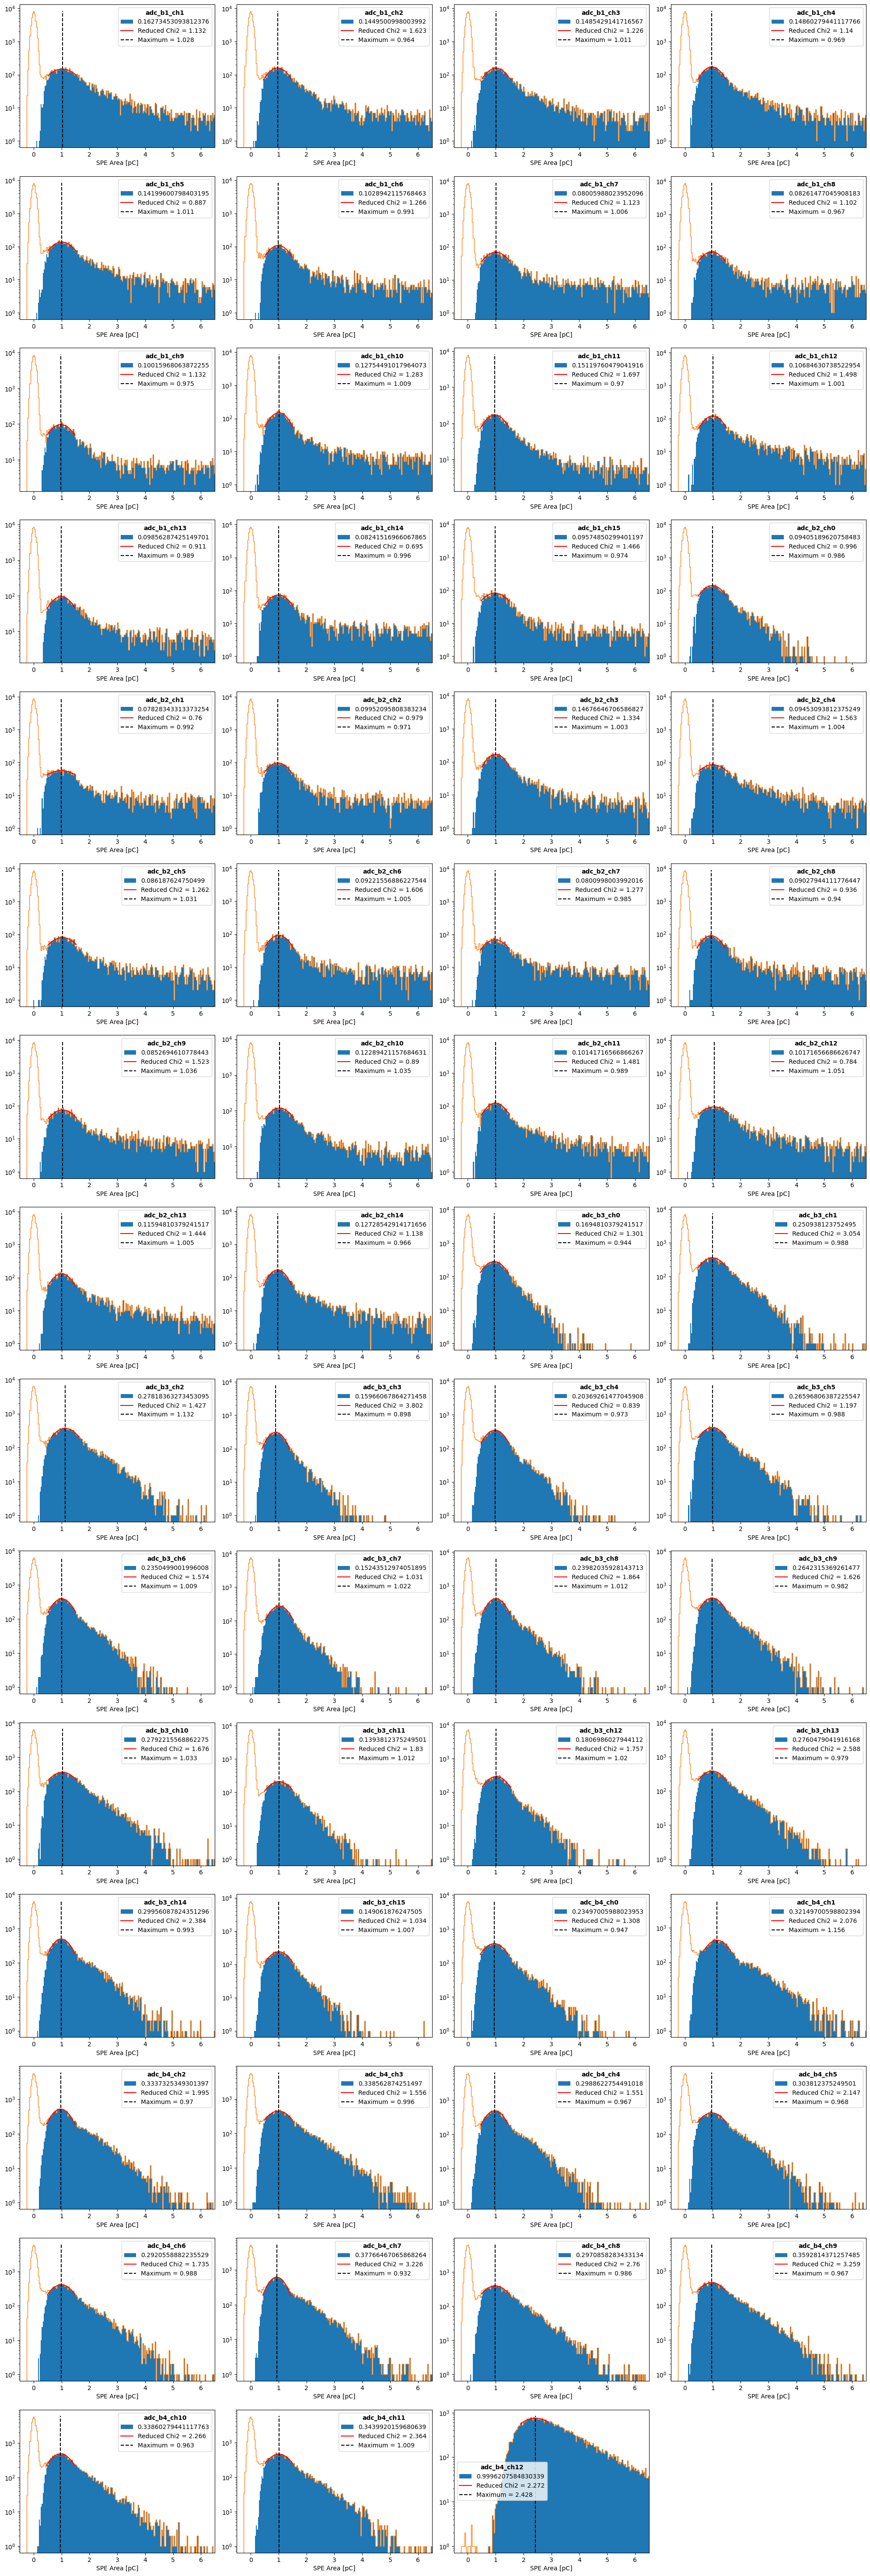

In [ ]:
tubes=r.all()#fitting all with gaussian for the moment

nTubes=len(tubes.keys())


results={}

def calc_chi2(func, xdata, ydata, popt):
    y = func(xdata, popt[0], popt[1], popt[2])
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)



from scipy.stats import chi2

def calc1SigmaGaussianMeanError(xdata,ydata,popt,steps=10):
    muOpt=popt[0]

    deltachi2=chi2.ppf(1-.683,len(xdata)-3)

    chi2Opt=calc_chi2(gauss,xdata,ydata,popt)
    
    #find negative error
    iterationDepthLimit=steps
    upperBound=muOpt
    lowerBound=xdata[0]
    muErrNeg=(lowerBound+upperBound)/2
    chi2Err=calc_chi2(gauss,xdata,ydata,[muErrNeg,popt[1],popt[2]])
    while iterationDepthLimit and abs(chi2Err-chi2Opt)>0.001:
        if chi2Err-chi2Opt>deltachi2:
            lowerBound=muErrNeg
        if chi2Err-chi2Opt<deltachi2:
            upperBound=muErrNeg
        muErrNeg=(lowerBound+upperBound)/2
        chi2Err=calc_chi2(gauss,xdata,ydata,[muErrNeg,popt[1],popt[2]])
        iterationDepthLimit-=1
    errNeg=muOpt-muErrNeg


    #find positive error
    iterationDepthLimit=steps
    upperBound=xdata[-1]
    lowerBound=muOpt
    muErrPos=(lowerBound+upperBound)/2
    chi2Err=calc_chi2(gauss,xdata,ydata,[muErrPos,popt[1],popt[2]])
    while iterationDepthLimit and abs(chi2Err-chi2Opt)>0.001:
        if chi2Err-chi2Opt>deltachi2:
            upperBound=muErrPos
        if chi2Err-chi2Opt<deltachi2:
            lowerBound=muErrPos
        muErrPos=(lowerBound+upperBound)/2
        chi2Err=calc_chi2(gauss,xdata,ydata,[muErrPos,popt[1],popt[2]])
        iterationDepthLimit-=1
    errPos=muErrPos-muOpt

    return [errNeg,errPos]


def calc1SigmaGaussianWidthError(xdata,ydata,popt,steps=10):
    sigmaOpt=popt[1]

    deltachi2=chi2.ppf(1-.683,len(xdata)-3)

    chi2Opt=calc_chi2(gauss,xdata,ydata,popt)
    
    #find negative error
    iterationDepthLimit=steps
    upperBound=sigmaOpt
    lowerBound=0
    sigmaErrNeg=(lowerBound+upperBound)/2
    chi2Err=calc_chi2(gauss,xdata,ydata,[popt[0],sigmaErrNeg,popt[2]])
    while iterationDepthLimit and abs(chi2Err-chi2Opt)>0.001:
        if chi2Err-chi2Opt>deltachi2:
            lowerBound=sigmaErrNeg
        if chi2Err-chi2Opt<deltachi2:
            upperBound=sigmaErrNeg
        sigmaErrNeg=(lowerBound+upperBound)/2
        chi2Err=calc_chi2(gauss,xdata,ydata,[popt[0],sigmaErrNeg,popt[2]])
        iterationDepthLimit-=1
    errNeg=sigmaOpt-sigmaErrNeg

    #find positive error
    iterationDepthLimit=steps
    upperBound=2*sigmaOpt
    lowerBound=sigmaOpt
    sigmaErrPos=(lowerBound+upperBound)/2
    chi2Err=calc_chi2(gauss,xdata,ydata,[popt[0],sigmaErrPos,popt[2]])
    while iterationDepthLimit and abs(chi2Err-chi2Opt)>0.001:
        if chi2Err-chi2Opt>deltachi2:
            upperBound=sigmaErrPos
        if chi2Err-chi2Opt<deltachi2:
            lowerBound=sigmaErrPos
        sigmaErrPos=(lowerBound+upperBound)/2
        chi2Err=calc_chi2(gauss,xdata,ydata,[popt[0],sigmaErrPos,popt[2]])
        iterationDepthLimit-=1
    errPos=sigmaErrPos-sigmaOpt

    return [errNeg,errPos]
    
tubeSumAll=[]
tubeSum12=[]
tubeSum34=[]
tubeSum567=[]
tubeSumBot=[]
p0s={}
for tube in tubes:
    p0s[tube]=[1,0.4,1e5]

plt.figure(figsize=(20,nTubes))

for n,tube in enumerate([tube for tube in wbls_vars.tubeNamesSorted if tube in tubes.keys()]):
    ax=plt.subplot(math.ceil(nTubes/4),4,n+1)
    var=wbls_code.eventVars(tubes[tube])
    var.mask(aVar.peakMask())
    var.dataFrac(1)
    
    #var.cuts()
    var.calculateVars()
    peakOver5Mask=[mV>5 for mV in var.roiMax()]
    population=np.sum(peakOver5Mask)/len(peakOver5Mask)
    histData=var.roiCharge()[peakOver5Mask]
    h=plt.hist(histData,bins=200,range=[-0.25,6.5],label=population)
    plt.hist(var.roiCharge(),bins=200,range=[-0.25,6.5],histtype='step',)
    modeBin=np.argmax(h[0])#initially fit to try and find center to fit around
    modeCharge=h[1][modeBin]
    xdata = ((h[1][1:]+h[1][:-1])/2)
    xmask=[(modeCharge-0.5)<charge<(modeCharge+0.5) for charge in xdata]
    ydata = h[0][xmask]
    xdata=xdata[xmask]
    try:
        poptInit,pcovInit=curve_fit(gauss,xdata,ydata,p0=p0s[tube])#fitting is quick. do an initial fit around the mode to try and find a good region for the final fit
        xdata = ((h[1][1:]+h[1][:-1])/2)
        xmask=[(poptInit[0]-0.5)<charge<(poptInit[0]+0.5) for charge in xdata]
        ydata = h[0][xmask]
        xdata=xdata[xmask]
        #plt.ylim(bottom=1e-3,top=5)
        
        popt,pcov=curve_fit(gauss,xdata,ydata,p0=p0s[tube])
        meanErr=np.sqrt(pcov[0][0])
        widthErr=np.sqrt(pcov[1][1])
        wildGuess=wbls_vars.channelHVValues[tube]*((1/popt[0])**(1/9))
        #print(int(tube[5:6]+('0' if len(tube[9:])==1 else '')+tube[9:]),wbls_vars.channelHVNames[tube],round(popt[0],3),'wild guess {}'.format(wildGuess))   
        print(int(tube[5:6]+('0' if len(tube[9:])==1 else '')+tube[9:]),round(popt[0],3),'population={}'.format(population))
        err = np.sqrt(np.diag(pcov))
        dof=len(xdata)-2
        results[tube]={'ch_id':int(tube[5:6]+('0' if len(tube[9:])==1 else '')+tube[9:]),
                       'ch_name':tube,
                       'pmt':wbls_vars.channelPMTNames[tube],
                       'spe_mean': popt[0],
                       'spe_width': popt[1],
                       'chi2': calc_chi2(gauss,xdata,ydata,popt),
                       'dof': dof,
                       'spe_mean_err': meanErr,
                       'spe_width_err': widthErr,
                       'HV': wbls_vars.channelHVValues[tube],
                       }
        a=np.linspace(poptInit[0]-0.5,poptInit[0]+0.5,200)
        plt.plot(a,gauss(a,popt[0],popt[1],popt[2]),color='red',label='Reduced Chi2 = {}'.format(round(calc_chi2(gauss,xdata,ydata,popt)/(len(xdata)-3),3)))
        plt.vlines(popt[0], 0,plt.ylim()[1], color='black', linestyle='dashed', label='Maximum = {}'.format(round(popt[0],3)))
        #plt.vlines([popt[0]-meanErr,popt[0]+meanErr],0,1e5,color='red',linestyle='dashed')
        tubeSumAll.append(var.roiCharge()/popt[0])
        if tube in r.upper(listOnly=True):
            tubeSum12.append(var.roiCharge()/popt[0])
        if tube in r.middle(listOnly=True):
            tubeSum567.append(var.roiCharge()/popt[0])
        if tube in r.lower(listOnly=True):
            tubeSum34.append(var.roiCharge()/popt[0])
        if tube in r.bottom(listOnly=True):
            tubeSumBot.append(var.roiCharge()/popt[0])
        #plt.text(4, 1e2, 'chi2/dof={}'.format(calc_chi2(gauss,xdata,ydata,popt)/(len(xdata)-3)))
           
    except RuntimeError:
        wildGuess=wbls_vars.channelHVValues[tube]*((1/modeCharge)**(1/9))
        print(int(tube[5:6]+('0' if len(tube[9:])==1 else '')+tube[9:]),modeCharge,'population={}'.format(population))
    
    plt.yscale('log')
    plt.xlabel('SPE Area [pC]')
    plt.xlim(-0.5, 6.5)
    plt.legend(title=tube,title_fontproperties={'weight':'bold'})
plt.tight_layout()
plt.show()

In [ ]:
rootWater='/media/disk_c/gglawley/consolidated/phase3/muon_full_test_240417T0928.root'
rWater=wbls_code.arrays(rootWater)

'''
rootNoWater='/media/disk_c/gglawley/consolidated/phase3/muon_full_test_240417T1733.root'
rNoWater=wbls_code.arrays(rootNoWater)



varWater=wbls_code.event_vars(rWater.alpha())
varNoWater=wbls_code.event_vars(rNoWater.alpha())
varWater.mask(varWater.peakMask())
varWater.calculateVars()
varNoWater.mask(varNoWater.peakMask())
varNoWater.calculateVars()

histData=varWater.roiCharge()

plt.hist(histData,bins=200,range=[-0.25,6.5],
            histtype='step'
            )

'''
modeBin=np.argmax(h[0])#initially fit to try and find center to fit around
modeCharge=h[1][modeBin]
xdata = ((h[1][1:]+h[1][:-1])/2)
xmask=[(modeCharge-0.5)<charge<(modeCharge+0.5) for charge in xdata]
ydata = h[0][xmask]
xdata=xdata[xmask]

poptInit,pcovInit=curve_fit(gauss,xdata,ydata,p0=p0s[tube])#fitting is quick. do an initial fit around the mode to try and find a good region for the final fit
xdata = ((h[1][1:]+h[1][:-1])/2)
xmask=[(poptInit[0]-0.5)<charge<(poptInit[0]+0.5) for charge in xdata]
ydata = h[0][xmask]
xdata=xdata[xmask]
#plt.ylim(bottom=1e-3,top=5)

popt,pcov=curve_fit(gauss,xdata,ydata,p0=p0s[tube])
print(popt)
#print(popt, calc_chi2(gauss,xdata,ydata,popt)/(len(xdata)-3))
err = np.sqrt(np.diag(pcov))
dof=len(xdata)-2
a=np.linspace(poptInit[0]-0.5,poptInit[0]+0.5,200)

meanErrs=calc1SigmaGaussianMeanError(xdata,ydata,popt)
print(len(xdata)-3)
widthErrs=calc1SigmaGaussianWidthError(xdata,ydata,popt)

plt.plot(a,gauss(a,popt[0],popt[1],popt[2]),color='red')
#plt.plot(a,gauss(a,popt[0]-meanErrs[0],popt[1],popt[2]),color='grey',linestyle='dashed')
#plt.plot(a,gauss(a,popt[0]+meanErrs[1],popt[1],popt[2]),color='grey',linestyle='dashed')
#plt.plot(a,gauss(a,popt[0],popt[1]-widthErrs[0],popt[2]),color='green',linestyle='dashed')
plt.plot(a,gauss(a,popt[0],popt[1]+widthErrs[1],popt[2]),color='green',linestyle='dashed')
plt.vlines([popt[0],popt[0]-meanErrs[1],popt[0]+meanErrs[0]], 0, 1e3, color='black', linestyle='dashed', label='maximum = {}'.format(round(popt[0],3)))
plt.vlines(2*popt[0], 0, 1e3, color='black', linestyle='dotted', label='2 PE')
plt.legend(title=tube,title_fontproperties={'weight':'bold'})

plt.yscale('log')
plt.xlabel('SPE Area [pC]')
plt.xlim(-0.5, 20)


plt.tight_layout()
#plt.savefig('b1_ch4.pdf')
plt.show

FileNotFoundError: file not found

    '/media/disk_c/gglawley/consolidated/phase3/muon_full_test_240417T0928.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


[0.375333196330109, 0.3837039878623063]
[1.58271058e+01 5.58898174e+00 1.02324987e+04]


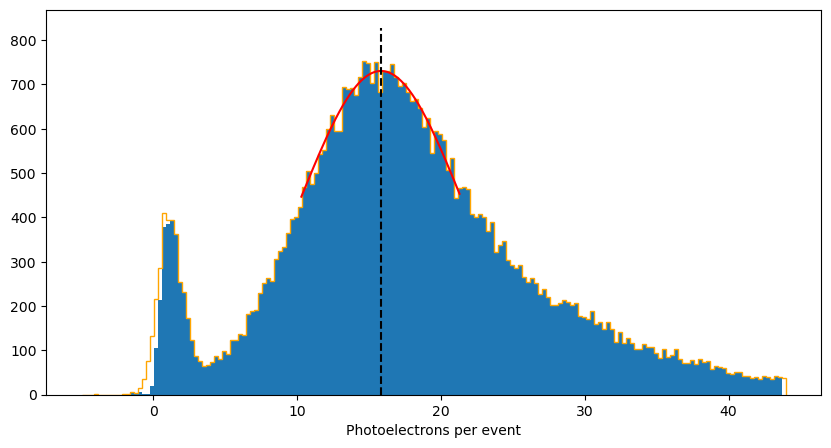

[0.218290674128645, 0.21843761621128355]
[5.86308655e+00 3.78417722e+00 1.42408244e+04]


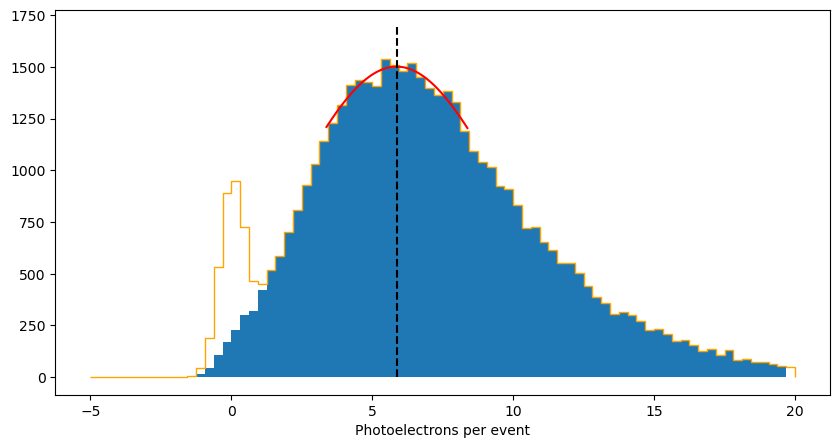

[0.012405081345106206, 0.05231520928055078]
[1.64729079e+00 1.36294555e+00 1.32920395e+04]


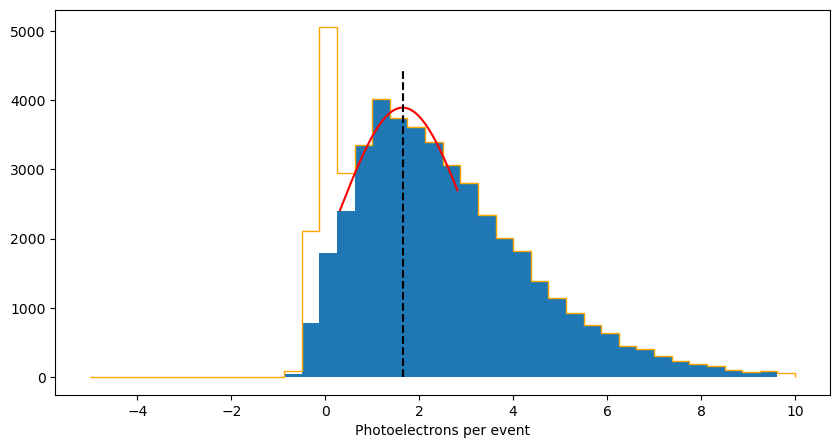

[0.009033483390134212, 0.053888886477927]
[1.52576906e+00 1.28992867e+00 1.35782897e+04]


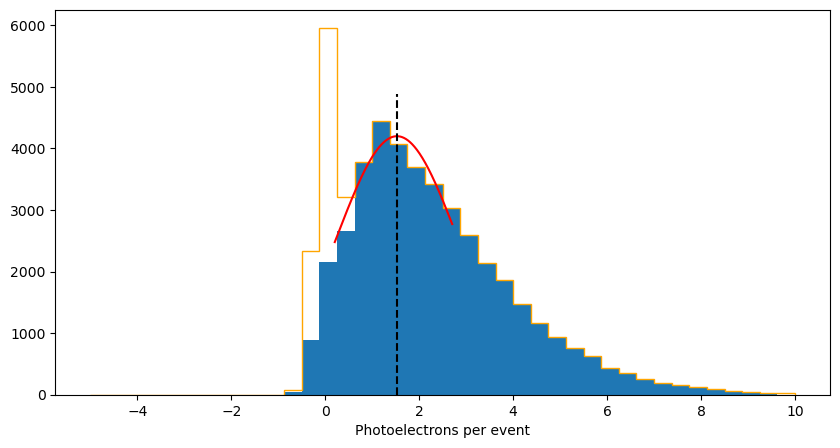

[0.11069227654400038, 0.1297627856401542]
[5.45993442e+00 2.87319998e+00 1.28054995e+04]


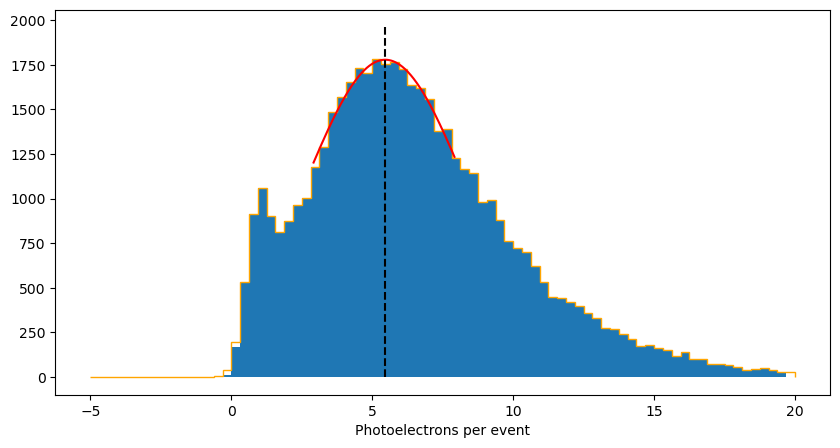

In [ ]:
tubeSumDict={'all':tubeSumAll,'bottom':tubeSumBot,'12':tubeSum12,'34':tubeSum34,'567':tubeSum567}

for group in tubeSumDict.keys():
    if group=='all':
        histRange=44
    elif group=='bottom':
        histRange=20
    elif group=='12':
        histRange=10
    elif group=='34':
        histRange=10
    else:
        histRange=20
    numBins=(histRange)*4
    total=np.sum(np.array(tubeSumDict[group]),axis=0)

    #fit gaussian around pedestal
    hPedestal=np.histogram(total,bins=24,
               range=(-5,1),
               density=False)
    
    xdataPedestal = ((hPedestal[1][1:]+hPedestal[1][:-1])/2)
    xmaskPedestal=[-2<charge<0 for charge in xdataPedestal]
    ydataPedestal = hPedestal[0][xmaskPedestal]
    xdataPedestal=xdataPedestal[xmaskPedestal]

    poptPedestal,pcovPedestal=curve_fit(lambda xdata,sigma,scale:gauss(xdata,0,sigma,scale),xdataPedestal,ydataPedestal)

    #histogram of all charges
    h=np.histogram(total,bins=numBins,
               range=(-5,histRange),
               density=False)
    xdata=((h[1][1:]+h[1][:-1])/2)
    #correct y data by subtracting pedestal, note that these values are now floats
    ydata=h[0]-gauss(xdata,0,poptPedestal[0],poptPedestal[1])
    plt.figure(figsize=(10,5))
    plt.hist(xdata,h[1][:-1],weights=ydata)
    plt.hist(total,bins=numBins,
               range=(-5,histRange),
               density=False,histtype='step',color='orange')

    mode=xdata[np.argmax(ydata)]
    xmask=[(mode-histRange/8)<charge<(mode+histRange/8) for charge in xdata]
    xdataInit=xdata[xmask]
    ydataInit=ydata[xmask]
    #fitting is fast, do an initial fit to find center to fit around
    poptInit,pcovInit=curve_fit(gauss,xdataInit,ydataInit,p0=[mode,2,1e4])
    xmask=[(poptInit[0]-histRange/8)<charge<(poptInit[0]+histRange/8) for charge in xdata]
    xdata=xdata[xmask]
    ydata=ydata[xmask]
    popt,pcov=curve_fit(gauss,xdata,ydata,p0=[poptInit[0],poptInit[1],poptInit[2]])
    meanErrs=calc1SigmaGaussianMeanError(xdata,ydata,popt)
    print(meanErrs)
    print(popt)
    plotFitOver=np.linspace(poptInit[0]-(histRange/8),poptInit[0]+(histRange/8),350)
    plt.plot(plotFitOver, gauss(plotFitOver,popt[0],popt[1],popt[2]), color='red',label='Gaussian Fit')
    plt.vlines(popt[0],0,1.1*np.max(ydata),color='black',linestyle='dashed')
    plt.xlabel('Photoelectrons per event')
    #plt.ylabel('Relative probability',fontsize='x-large')
    #plt.title('{}'.format(group),size='xx-large')
    #plt.legend()
 
    if group=='all':
        plt.savefig('alpha_all.pdf',format='pdf')
    plt.show()
    histMax=np.sort(total)[math.floor(0.999*len(total))]
    
total=np.sum(np.array(tubeSumDict['all']),axis=0)
hn=np.histogram(total,bins=100,range=(-5,60))

In [ ]:
import pickle
try:
    with open('/home/gglawley/analysis/sumSPEList.pkl','rb') as file:
        sumDict=pickle.load(file)
    sumDict[r.datetime()]={'mean':popt[0],'max':histMax}
    with open('/home/gglawley/analysis/sumSPEList.pkl','wb') as file:
        pickle.dump(sumDict,file)
except FileNotFoundError:
    with open('/home/gglawley/analysis/sumSPEList.pkl','wb') as file:
        sumDict={r.datetime():{'mean':popt[0],'max':histMax}}
        pickle.dump(sumDict,file)

In [ ]:
import pickle
with open('/home/gglawley/analysis/sumSPEList.pkl','rb') as file:
        sumDict=pickle.load(file)
        
        print(sumDict)

In [ ]:
import datetime as dt
import matplotlib.dates as mdates
plt.figure(figsize=(40,12))
dayList=[(dt.datetime.strptime(day, "%y%m%dT%H%M"),sumDict[day]['mean']) for day in sumDict.keys()]
dayList.sort(key=lambda day:day[0])

timeList=[day[0] for day in dayList]
timeDeltaList=[(time-timeList[0]).seconds for time in timeList]
meanList=[day[1] for day in dayList]
popt,pcov = curve_fit(lambda x,a,b:a*x+b, timeDeltaList, np.array(meanList))
xpts=np.linspace
print(np.mean(meanList))
print(np.std(meanList),np.std(meanList)/np.mean(meanList))
plt.figure(figsize=(12,6))
plt.plot(timeList,meanList)
plt.ylim(10,15)
plt.xlabel('Date')
plt.ylabel('Photoelectrons')
plt.title("Alpha Stability, Side Tubes")
plt.vlines(dt.datetime(2023, 6, 27, 0,0),0,15,color='black',linestyles='dotted',label='1% -> 2%')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gcf().autofmt_xdate()

TypeError: strptime() argument 1 must be str, not datetime.datetime

<Figure size 4000x1200 with 0 Axes>

In [ ]:
a=timeList[-1]-timeList[0]
a.seconds
